In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import time

from dataset import SyntheticTimeSeriesDataset
from models.mlp import MLPDenoiser
from models.transformer import TransformerDenoiser
from models.unet import UNet1D
from noise_scheduler import NoiseScheduler
from diffusion import TimeSeriesDDPM
from train import train_model
from evaluation import evaluate_model


{'full_series': tensor([-0.4883, -0.4876, -0.4540, -0.4611, -0.4275, -0.3781, -0.3503, -0.3652,
        -0.2880, -0.3096, -0.2593, -0.2141, -0.2640, -0.1520, -0.1750, -0.1833,
        -0.1236, -0.1282, -0.0364, -0.0220,  0.0198, -0.0109,  0.0177,  0.0163,
         0.0854,  0.2109,  0.1533,  0.1734,  0.2258,  0.2287,  0.2216,  0.2533,
         0.2301,  0.3564,  0.3317,  0.2946,  0.3873,  0.3373,  0.4103,  0.3697,
         0.4174,  0.3975,  0.4318,  0.3846,  0.5030,  0.4021,  0.4782,  0.4365,
         0.4093,  0.4259,  0.4948,  0.4093,  0.4432,  0.4034,  0.4034,  0.3579,
         0.3672,  0.3495,  0.3129,  0.3180,  0.3178,  0.2699,  0.2607,  0.2638,
         0.2678,  0.1918,  0.1997,  0.1527,  0.1363,  0.0844,  0.0617, -0.0414,
         0.0341, -0.0371, -0.0100, -0.0372, -0.0885, -0.1181, -0.1289, -0.2000,
        -0.2185, -0.2483, -0.1545, -0.2706, -0.3245, -0.3418, -0.3873, -0.4517,
        -0.3613, -0.3899, -0.4680, -0.4729, -0.4844, -0.5207, -0.5337, -0.5399,
        -0.5361, -0.5620

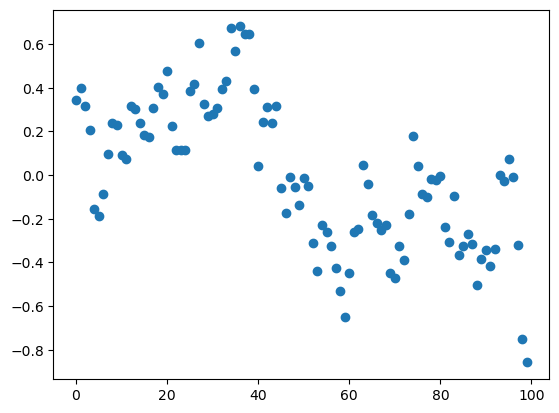

In [12]:
seq_lenght = 100
condition_lenght = 50
num_samples = 4
task = 'forecasting'

# Create dataset
dataset = SyntheticTimeSeriesDataset(
    num_samples=num_samples,
    seq_lenght=seq_lenght,
    condition_lenght=condition_lenght,
    task_type=task
)

print(dataset[0])
y = dataset[3]['full_series']
plt.scatter(np.arange(0,len(y),1), y)
plt.show()

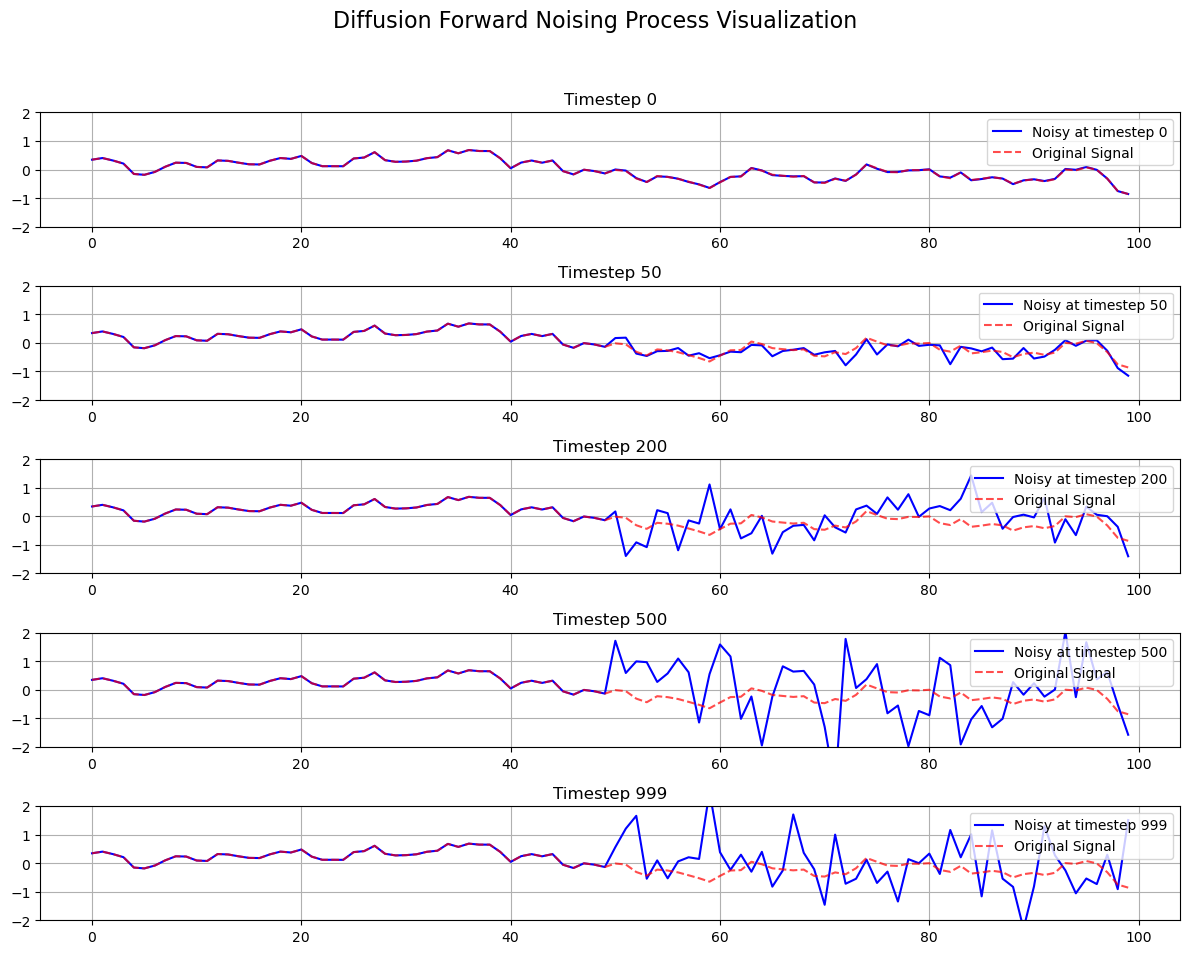

In [13]:
from util import visualize_forward_diffusion

scheduler = NoiseScheduler(num_timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule_type='linear')

# Generate a clean synthetic 1D signal: sine wave
clean_signal = dataset[3]['full_series']
mask = dataset[0]['mask']

# Visualize noise addition for a few selected timesteps
timesteps_to_show = [0, 50, 200, 500, 999]  # from clean to very noisy

# Call the visualization function
visualize_forward_diffusion(scheduler, clean_signal, mask, timesteps_to_show)


# simple mlp

Using device: cpu

Setting up for FORECASTING task

Creating dataset...
Dataset created with 1000 samples.
Initializing MLP Denoiser...
Denoiser model parameters: 214,356
Initializing Noise Scheduler...
Creating TimeSeriesDDPM model...

Starting Training for MLP on forecasting

Training on device: cpu
Epochloss_mask 10/200, Loss: 0.989371, Time: 0.08s
Epochloss_mask 20/200, Loss: 0.889722, Time: 0.07s
Epochloss_mask 30/200, Loss: 0.807102, Time: 0.05s
Epochloss_mask 40/200, Loss: 0.754699, Time: 0.05s
Epochloss_mask 50/200, Loss: 0.724215, Time: 0.05s
Epochloss_mask 60/200, Loss: 0.678400, Time: 0.05s
Epochloss_mask 70/200, Loss: 0.676241, Time: 0.05s
Epochloss_mask 80/200, Loss: 0.659652, Time: 0.04s
Epochloss_mask 90/200, Loss: 0.656619, Time: 0.05s
Epochloss_mask 100/200, Loss: 0.638174, Time: 0.05s
Epochloss_mask 110/200, Loss: 0.626085, Time: 0.05s
Epochloss_mask 120/200, Loss: 0.611858, Time: 0.05s
Epochloss_mask 130/200, Loss: 0.598389, Time: 0.04s
Epochloss_mask 140/200, Loss: 

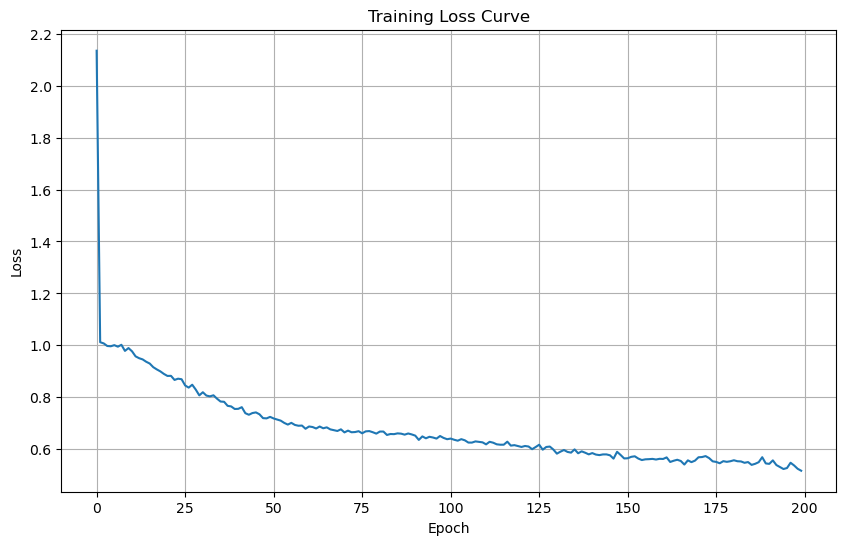

In [9]:
# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Dataset and training parameters
seq_lenght = 500
condition_lenght = 400
num_samples = 1000
batch_size = 128
num_epochs = 200
learning_rate = 0.001

# --- Task Definition ---
# Define the task type for the synthetic dataset
task_type = 'forecasting'
print(f"\n{'=' * 50}")
print(f"Setting up for {task_type.upper()} task")
print(f"{'=' * 50}\n")

# --- Dataset Setup ---
# Create the synthetic time series dataset
print("Creating dataset...")
dataset = SyntheticTimeSeriesDataset(
    num_samples=num_samples,
    seq_lenght=seq_lenght,
    condition_lenght=condition_lenght,
    task_type=task_type
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Dataset created with {len(dataset)} samples.")

# --- Model Initialization ---
# Define the denoiser architecture
arch_name = 'MLP'
print(f"Initializing {arch_name} Denoiser...")
denoiser = MLPDenoiser(seq_lenght, hidden_dim=128, num_layers=3)

# Count and display the number of trainable parameters in the denoiser
num_params = sum(p.numel() for p in denoiser.parameters() if p.requires_grad)
print(f"Denoiser model parameters: {num_params:,}")

# Initialize the noise scheduler
print("Initializing Noise Scheduler...")
noise_scheduler = NoiseScheduler(num_timesteps=1000, schedule_type='linear')

# Create the Denoising Diffusion Probabilistic Model (DDPM)
print("Creating TimeSeriesDDPM model...")
ddpm_model = TimeSeriesDDPM(denoiser, noise_scheduler, device=device)

# --- Model Training ---
print(f"\n{'=' * 50}")
print(f"Starting Training for {arch_name} on {task_type}")
print(f"{'=' * 50}\n")

start_time = time.time()
print(f"Training on device: {device}")

# Train the DDPM model
training_losses = train_model(
    ddpm_model,
    dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

training_time = time.time() - start_time
print("Training complete!")
print(f"Total training time: {training_time:.2f} seconds")

# Plot training_losses to visualize the learning curve.
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

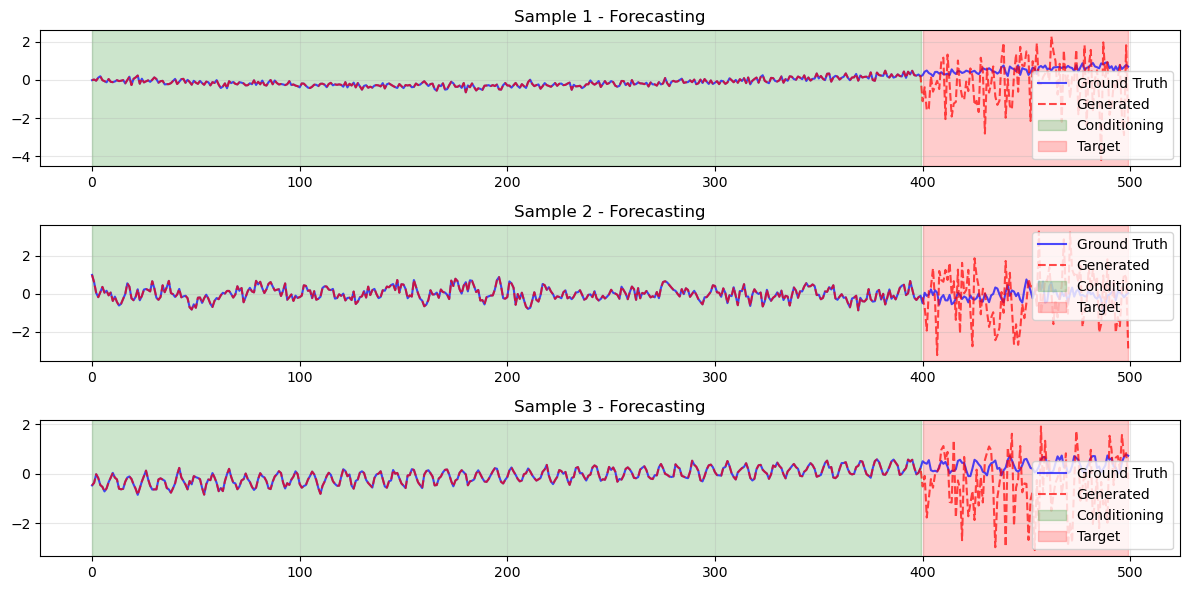

In [10]:
evaluate_model(ddpm_model, dataset, num_samples=3, num_inference_steps=50)

# Unet1D